In [ ]:
pip install nibabel 


In [1]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Mounted at /content/gdrive/


In [5]:
from skimage import measure
from skimage.morphology import skeletonize_3d
import matplotlib.pyplot as plt
from skimage.util import invert
import skimage.morphology
import nibabel as nib
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import circle

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

Read a 3D image using the get_data method: 




In [4]:
def read_img(path):
  img = nib.load(path)
  return img.get_fdata()

In [ ]:
img = read_img('/content/gdrive/MyDrive/Targil1_data/Case2_CT.nii.gz')
img.shape

(512, 512, 451)

Then we have a look at slices over the first, second and third dimensions of the array.

In [7]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
      axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [8]:
import matplotlib.pyplot as plt
def my_show(img_data):
  h,w,d = img_data.shape
  slice_0 = img_data[h//2, :, :]
  slice_1 = img_data[:, w//2, :]
  slice_2 = img_data[:, :, d//2]
  show_slices([slice_0, slice_1, slice_2])
  plt.suptitle("Center slices for EPI image")

#PART 1

SegmentationByTH(nifty_file, Imin, Imax):
This function is given as inputs a grayscale NIFTI file (.nii.gz) and two integers – the minimal and maximal thresholds. The function generates a segmentation NIFTI file of the same dimensions, with a binary segmentation – 1 for voxels between Imin and Imax, 0 otherwise. This segmentation NIFTI file should be saved under the name <nifty_file>_seg_<Imin>_<Imax>.nii.gz.
The function returns 1 if successful, 0 otherwise. Preferably, raise descriptive errors when returning 0.

In [21]:
def SegmentationByTH_Helper(img,Imin, Imax=1300):
    data_img = img.get_fdata()
    im = np.where((data_img<=Imax) & (data_img>=Imin), 1, 0)
    return im.astype('<f8')

In [20]:
import numpy as np
from termcolor import colored
import nibabel as nib


def SegmentationByTH(nifty_file, Imin, Imax=1300):
  mount_path = '/content/gdrive/MyDrive/Targil1_data/'
  nifty_file_nii = nifty_file + '.nii.gz'
  path =  mount_path + nifty_file_nii
  img = nib.load(path)
  try:
    im=SegmentationByTH_Helper(img,Imin,Imax)
    new_nifti = nib.Nifti1Image(im, img.affine)
    name  = nifty_file + '_seg_' + str(Imin) + '_' + str(Imax) + '.nii.gz'
    nib.save(new_nifti, name)
    return 1
  except:
    print(colored('No such file '+path+' Please mount drive and set nifty_file correctly',
                  color='red'))
    return 0

Recall that bones have a maximal HU value of 1000+, so 1300 will do as the Imax for the segmentation.
The value of Imin is a bit trickier. You’ll need to search for an optimal one:

In [ ]:
SegmentationByTH('Case5_CT',204)

1

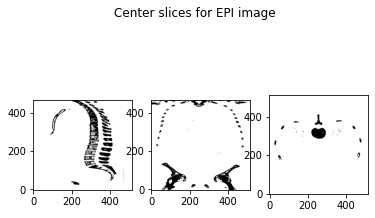

In [ ]:
img = read_img('/content/Case5_CT_seg_204_1300.nii.gz')
my_show(img)

Single connectivity component




In [19]:
def post_processing(data_img):
  # Helper function to find min_size in order to be left with single connectivity component
  h,w,d = data_img.shape
  num_of_pixels = h*w*d
  num_of_non_zero = np.count_nonzero(data_img)
  num_of_black_pixels = num_of_pixels - num_of_non_zero
  min_size = num_of_black_pixels//(2*d)
  print("min size is ",min_size)
  data_img = data_img.astype(bool)
  data = skimage.morphology.remove_small_holes(data_img, min_size, connectivity=1)
  print("after remove_small_holes ",measure.label(data, return_num=True)[1])
  data = skimage.morphology.remove_small_objects(data_img, min_size=min_size, connectivity=1)
  print("after remove_small_objects ",measure.label(data, return_num=True)[1])
  return data

This function iterates over 25 candidate Imin thresholds in the range of [150,500] (with intervals of 14). In each run, use the SegmentationByTH function you’ve implemented, and count the number of connectivity components in the resulting segmentation with the current Imin.
Plot your results – number of connectivity components per Imin. Choose the Imin which is the first or second minima in the plot. Also, make sure to include that graph in your report.
Next, you need to perform post-processing (morphological operations – clean out single pixels, close holes, etc.) until you are left with a single connectivity component.
Finally, this function should save a segmentation NIFTI file called “<nifty_file>_SkeletonSegmentation.nii.gz” and return the Imin used for that.

In [18]:
def SkeletonTHFinder(nifty_file):
   num_of_con_comp= []
   Imin_arr=[]
   mount_path = '/content/gdrive/MyDrive/Targil1_data/'
   nifty_file_nii = nifty_file + '.nii.gz'
   path =  mount_path + nifty_file_nii
   img = nib.load(path)
   for Imin in range(150,500,14):
      BW = SegmentationByTH_Helper(img,Imin)
      CC = measure.label(BW, return_num=True)
      Imin_arr.append(Imin)
      num_of_con_comp.append(CC[1])
   plt.title("Number of Connectivity Components Per Imin")
   plt.plot(Imin_arr, num_of_con_comp)
   plt.xlabel("Imin")
   plt.ylabel("Number of Connectivity Components")
   plt.show()
   num_of_con_comp_np = np.array(num_of_con_comp)
   minima_index = np.argmin(num_of_con_comp_np)
   chosen_Imin = Imin_arr[minima_index]
  #  print(num_of_con_comp_np,Imin_arr)
   data_img = SegmentationByTH_Helper(img,chosen_Imin)
   my_show(data_img)
   data = post_processing(data_img)
  #  print(data.dtype)
   my_show(data)
   try:
    #creating new NiftiImage
    new_nifti = nib.Nifti1Image(data.astype('<f8'), img.affine)
    #saving the nifti file.
    name  = nifty_file + '_SkeletonSegmentation.nii.gz'
    nib.save(new_nifti, name) 
   except:
     print("Could not save file")
   return chosen_Imin


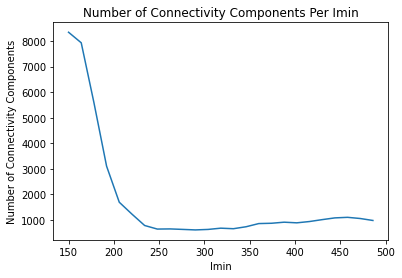

min size is  128380
after remove_small_holes  615
after remove_small_objects  1
bool


290

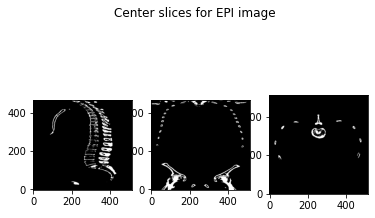

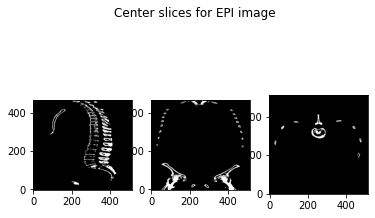

In [9]:
SkeletonTHFinder('Case5_CT')

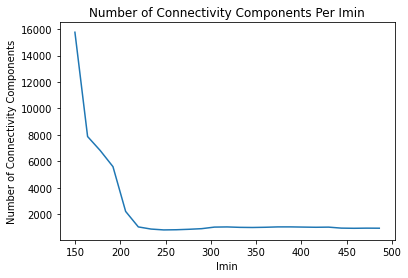

min size is  129464
after remove_small_holes  803
after remove_small_objects  1
bool


248

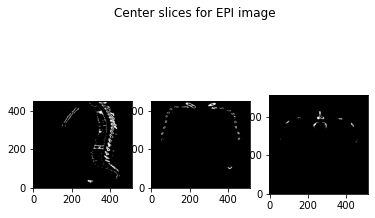

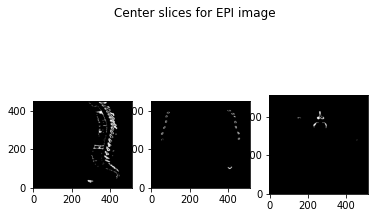

In [10]:
SkeletonTHFinder('Case4_CT')

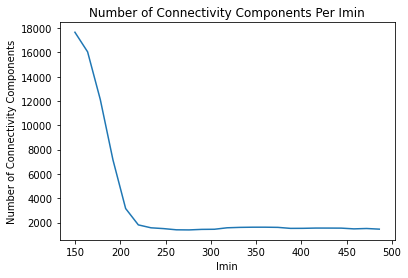

min size is  129008
after remove_small_holes  1390
after remove_small_objects  2


276

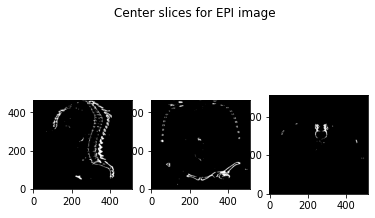

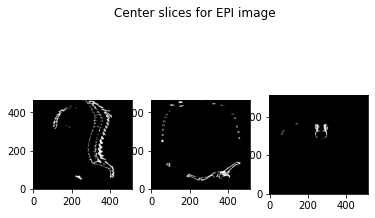

In [12]:
SkeletonTHFinder('Case3_CT')

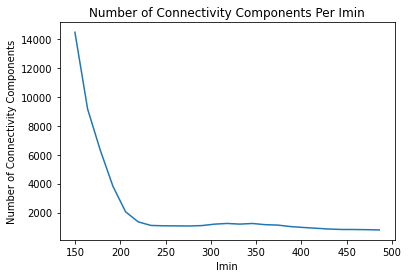

min size is  130343
after remove_small_holes  798
after remove_small_objects  4


486

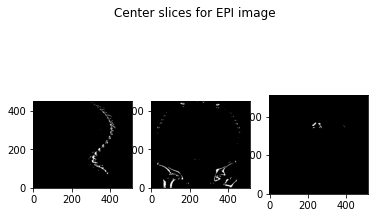

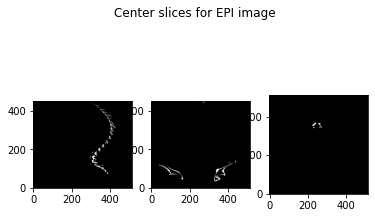

In [22]:
SkeletonTHFinder('Case2_CT')

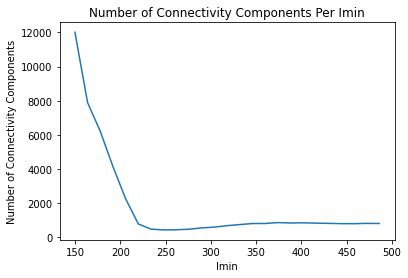

min size is  128249
after remove_small_holes  431
after remove_small_objects  2


248

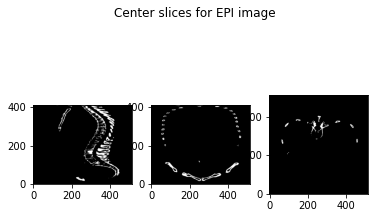

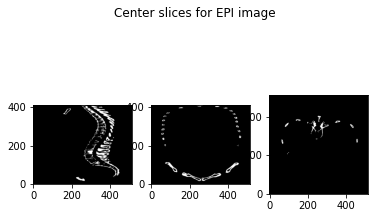

In [13]:
SkeletonTHFinder('Case1_CT')

#PART 2

In [ ]:
def read_images(nifty_file,L1_seg_nifti_file):
      mount_path = '/content/gdrive/MyDrive/Targil1_data/'
      img = nib.load(mount_path+nifty_file)
      img_data = img.get_data()
      seg = nib.load(mount_path+L1_seg_nifti_file)
      seg_data = seg.get_data()
      return img,img_data,seg_data

In [ ]:
def find_RIO(seg_data):    
    s, c, a = np.nonzero(seg_data)

    min_sag, max_sag = np.min(s), np.max(s)
    sag_mid = int((max_sag - min_sag) / 2)
    min_x = min_sag +  sag_mid//4
    max_x = max_sag - sag_mid

    min_cor, max_cor = np.min(c), np.max(c)
    cor_mid = (max_cor - min_cor) // 2
    min_y = min_cor - np.int(0.75 * cor_mid)
    max_y = max_cor - 2 * cor_mid

    min_z, max_z = np.min(a), np.max(a)
    return min_x,max_x, min_y,max_y, min_z,max_z

In [ ]:
def create_box(img_data,min_x,max_x, min_y,max_y, min_z,max_z):
    box = img_data[min_x:max_x, min_y:max_y, min_z:max_z]
    my_show(box)
    return box

In [ ]:
def find_circles(img_data,box):
    h,w,d = box.shape
    res = np.zeros_like(box)
    for i in range(d):
        edges = skimage.feature.canny(box[:,:,i])
        dil = skimage.morphology.dilation(edges)
        er = skimage.morphology.erosion(dil)
        # Detect two radii
        hough_radii = np.arange(15, 31,5)
        hough_res = hough_circle(er, hough_radii)
        # Select the most prominent 2 circles
        accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                                  total_num_peaks=1)
        for center_y, center_x, radius in zip(cy, cx, radii):
            circy, circx = circle(center_y, center_x, radius,shape = res.shape)
            res[circy, circx,i] = 1
    
    print(np.unique(res))
    my_show(res)
    return res


This function is given a grayscale NIFTI file and an L1 segmentation NIFTI file. Use the L1 segmentation to tell on which axial slices you are required to segment the aorta. You may work on 2D axial slices to perform the segmentation here, and assume we are looking for a circle in each slice.
As for the algorithm in this part, develop it yourself using ROI, thresholds and morphological operations. 

In [ ]:
def AortaSegmentation(nifty_file, L1_seg_nifti_file):
  img,img_data,seg_data = read_images(nifty_file,L1_seg_nifti_file)
  my_show(img_data)
  my_show(seg_data)
  min_x,max_x, min_y,max_y, min_z,max_z = find_RIO(seg_data)
  box = create_box(img_data,min_x,max_x, min_y,max_y, min_z,max_z)
  blur_im = skimage.filters.gaussian(box, sigma=1, output=None, mode='nearest', cval=0, multichannel=None, preserve_range=False, truncate=4.0)
  my_show(blur_im)
  res = find_circles(img_data,blur_im)
  final_res = np.zeros_like(img_data)
  final_res[min_x:max_x,min_y:max_y,min_z:max_z] = res
  my_show(final_res)
  print(np.unique(final_res))
  nifty_file_name = nifty_file.split(".")[0]
  img_name = nifty_file_name + "_Aorta_Seg_.nii.gz"
  #creating new NiftiImage
  new_nifti = nib.Nifti1Image(final_res.astype('<f8'), img.affine)
  #saving the nifti file.
  nib.save(new_nifti, img_name)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


[0. 1.]
[0. 1.]


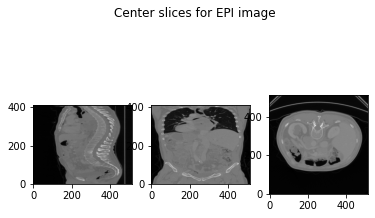

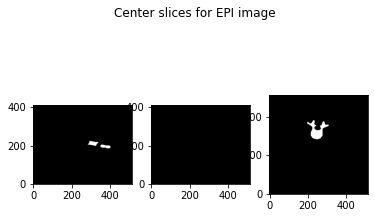

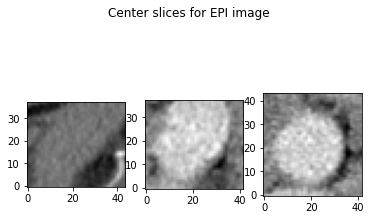

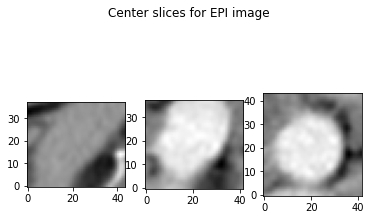

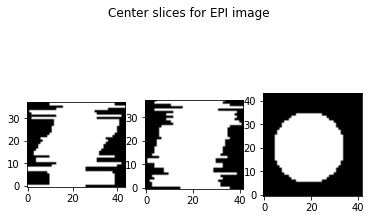

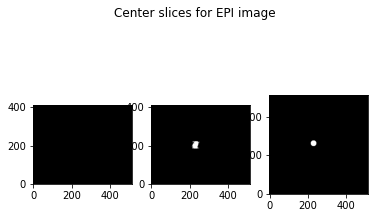

In [ ]:
nifty_file,L1_seg_nifti_file = "Case1_CT.nii.gz", "Case1_L1.nii.gz"
AortaSegmentation(nifty_file, L1_seg_nifti_file)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


[0. 1.]
[0. 1.]


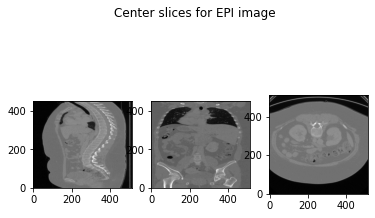

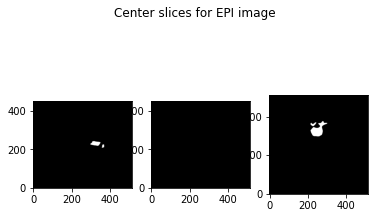

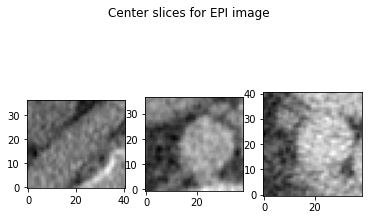

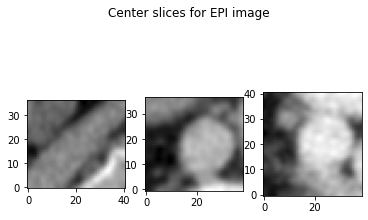

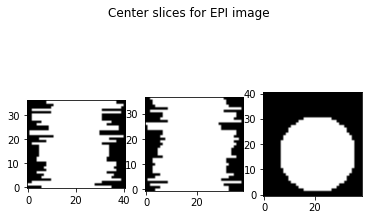

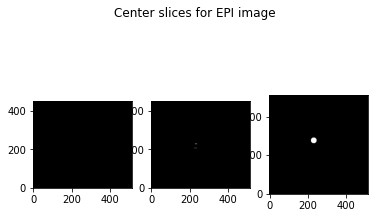

In [40]:
nifty_file,L1_seg_nifti_file = "Case2_CT.nii.gz", "Case2_L1.nii.gz"
AortaSegmentation(nifty_file, L1_seg_nifti_file)

For this part of the exercise, you are provided with Ground Truth segmentation NIFTI files of the aorta. To compare your results with the GT (whenever it is supplied.
This function is given two segmentations, a GT one and an estimated one, and returns a tuple of (VOD_result, DICE_result). Use the definitions from the lecture slides.

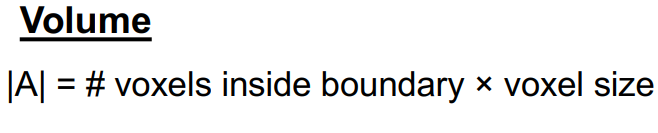

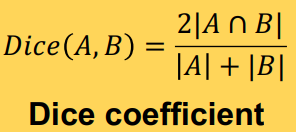

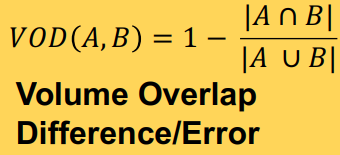

In [2]:
def evaluateSegmentation(GT_seg, est_seg):
    GT = nib.load(GT_seg)
    GT_data = GT.get_data()
    est = nib.load(est_seg)
    est_seg_data = est.get_data()
    my_show(GT_data)
    my_show(est_seg_data)
    GT_roi = ROI(GT_data,est_seg_data)
    my_show(GT_roi)
    union = np.logical_or(GT_roi, est_seg_data)
    intersection = np.logical_and(GT_roi, est_seg_data)
    my_show(union)
    my_show(intersection)
    sum_intersection = np.sum(intersection)
    sum_union = np.sum(union)
    VOD_res = 1 - (sum_intersection / sum_union)
    DICE_res = (2 * sum_intersection) / (np.sum(GT_roi)+np.sum(est_seg_data))
    return VOD_res, DICE_res

In [3]:
def ROI(GT_data,est_seg_data):
    s, c, a = np.nonzero(est_seg_data)
    roi = np.zeros_like(GT_data)
    roi[np.amin(s):np.amax(s), np.amin(c):np.amax(c), np.amin(a):np.amax(a)] = 1
    roi[GT_data<1]=0
    return roi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


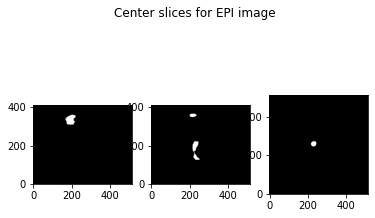

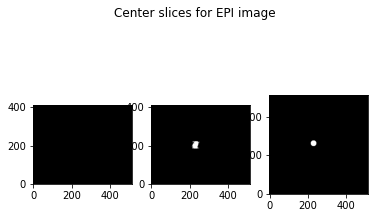

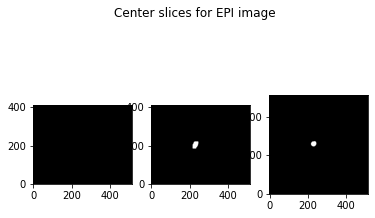

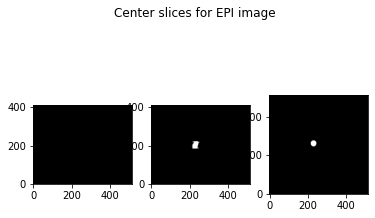

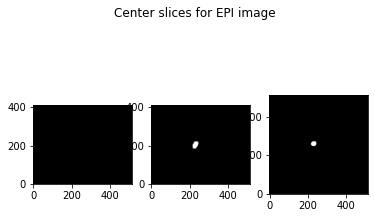

In [9]:
est_seg = '/content/gdrive/MyDrive/Case1_CT1_Aorta_Seg_.nii.gz'
GT_seg = '/content/gdrive/MyDrive/Targil1_data/Case1_Aorta.nii.gz'
VOD_res, DICE_res = evaluateSegmentation(GT_seg, est_seg)

In [10]:
print(VOD_res, DICE_res)

0.4357943864652881 0.7213957150553231


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


0.7372307033813668 0.41617941982317885


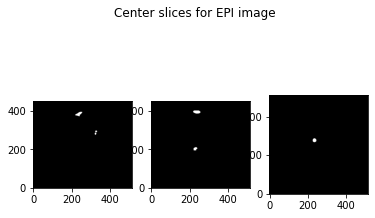

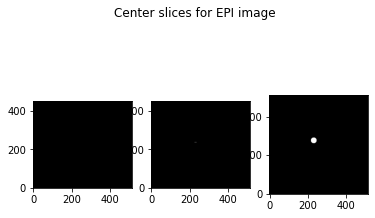

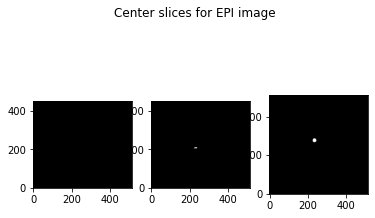

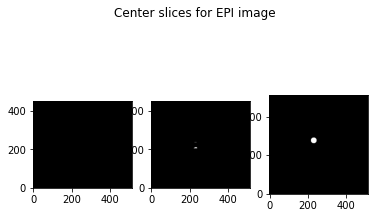

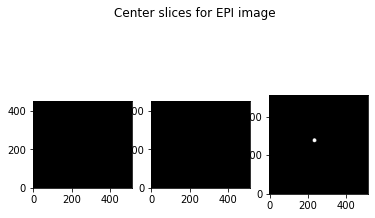

In [11]:
est_seg = '/content/gdrive/MyDrive/Case2_CT1_Aorta_Seg_.nii.gz'
GT_seg = '/content/gdrive/MyDrive/Targil1_data/Case2_Aorta.nii.gz'
VOD_res, DICE_res = evaluateSegmentation(GT_seg, est_seg)
print(VOD_res, DICE_res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


0.5747872986934063 0.5967006902433174


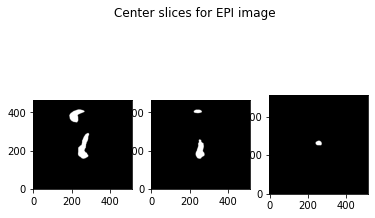

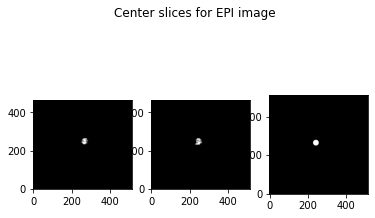

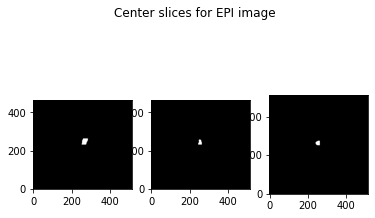

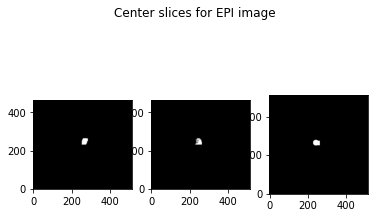

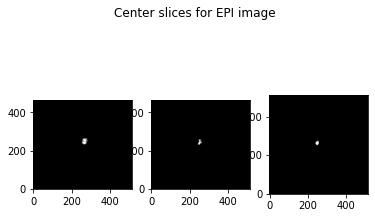

In [12]:
est_seg = '/content/gdrive/MyDrive/Case3_CT_Aorta_Seg_.nii.gz'
GT_seg = '/content/gdrive/MyDrive/Targil1_data/Case3_Aorta.nii.gz'
VOD_res, DICE_res = evaluateSegmentation(GT_seg, est_seg)
print(VOD_res, DICE_res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


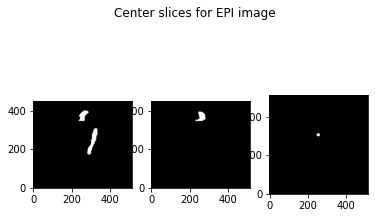

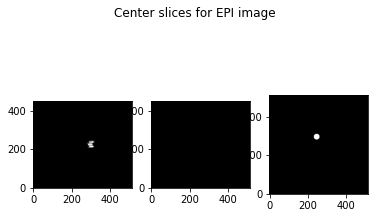

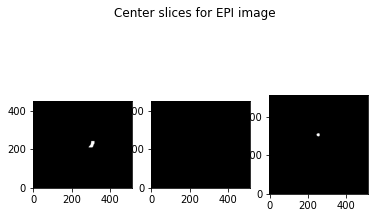

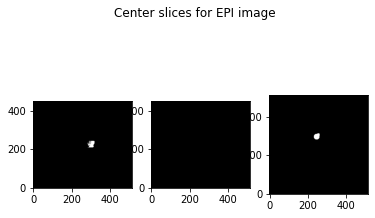

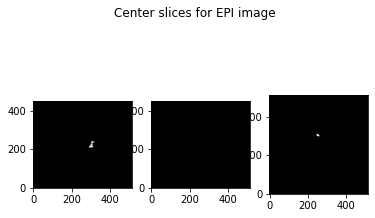

In [14]:
est_seg = '/content/gdrive/MyDrive/Case4_CT_Aorta_Seg_.nii.gz'
GT_seg = '/content/gdrive/MyDrive/Targil1_data/Case4_Aorta.nii.gz'
VOD_res, DICE_res = evaluateSegmentation(GT_seg, est_seg)

In [15]:
print(VOD_res, DICE_res)

0.786961995436305 0.35124704050854605
